In [1]:
import pennylane as qml
from pennylane import numpy as np

### Simple workflow:

In [3]:
qubit_register = [0, 1]
dev = qml.device("default.qubit", wires=qubit_register)


@qml.qnode(dev)
def circ(A, phi):
    qml.qsvt(A, phi, wires=[0, 1])  # apply qsvt!
    return qml.expval(qml.PauliZ(0))

phi = np.random.rand(3)
A = np.array([[0.1, 0.2], [0.3, 0.4]])
mat = qml.matrix(circ)(A, phi)


print("Matrix:\n", np.round(mat, 2))
print("\nGradient: ", qml.grad(circ, argnum=1)(A, phi))  # Can also take grad w.r.t A 

Matrix:
 [[ 0.01+0.11j  0.03+0.22j  0.4 +0.88j -0.03-0.07j]
 [ 0.04+0.33j  0.05+0.44j -0.03-0.07j  0.34+0.75j]
 [ 0.88+0.32j -0.09-0.03j -0.11-0.j   -0.33-0.01j]
 [-0.09-0.03j  0.81+0.29j -0.22-0.01j -0.44-0.02j]]

Gradient:  [-1.21430643e-17  1.30159921e-01  8.84623998e-02]


### General differentiable workflow:

In [4]:
qubit_register = ["ancilla", 0, 1]
dev = qml.device("default.qubit", wires=qubit_register)

@qml.qnode(dev)
def circ(a, phi):
    # Hadamard transform on the input register
    qml.Hadamard("ancilla")
    
    qml.ctrl(qml.qsvt, control="ancilla")(a, phi, wires=[0])  # apply controlled qsvt circuit!
    
    # Another Hadamard transform on the input register
    qml.Hadamard("ancilla")
    
    return qml.expval(qml.PauliZ("ancilla"))  # This circuit performs a "Hadamard Test" which extracts the
                                              # quantity Re(<0|U_qsvt|0>)
phi = np.random.rand(12)
print(circ(0.5, phi))

0.09757017984960359


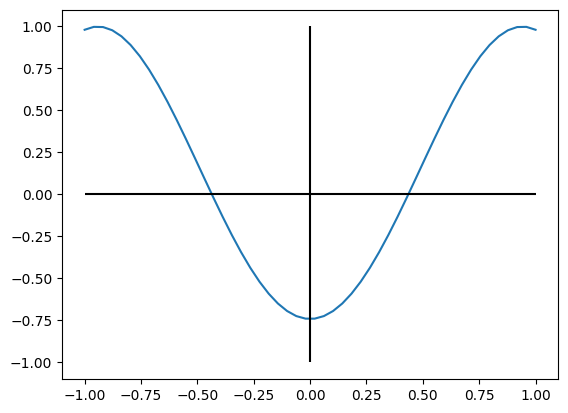

In [5]:
import matplotlib.pyplot as plt

samples_a = np.linspace(-1, 1, 50)            # Taking 50 samples of a degree 12 polynomial
phi = np.random.rand(12)

y_vals = [circ(a, phi) for a in samples_a]  # Generate polynomial transform over the sampels

plt.plot(samples_a, y_vals)
plt.vlines(0.0, -1.0, 1.0, color="black")
plt.hlines(0.0, -1.0, 1.0, color="black")
plt.show()

In [6]:
import copy

def target_poly(x):
    return 1/2 * (x**5 + x**3)

def mean_squared_error(phi):
    norm = 1 / len(samples_a)
    
    sum_square_error = 0
    for x in samples_a:
        sum_square_error += (circ(x, phi) - target_poly(x))**2
        
    return norm * sum_square_error


# Initialize parameters: 
phi = np.random.rand(5)
phi_initial = copy.copy(phi)

# Optimization:
opt = qml.AdagradOptimizer(0.3)
for epoch in range(30):  
    phi, cost = opt.step_and_cost(mean_squared_error, phi)
    if (epoch + 1) % 5 == 0:
        print(f"iter: {epoch+1}, cost: {cost}")

print("Completed Optimization!")

iter: 5, cost: 0.03582222791808051
iter: 10, cost: 0.029742088438837744
iter: 15, cost: 0.023331562888041755
iter: 20, cost: 0.016942076366157646
iter: 25, cost: 0.011254574913130668
iter: 30, cost: 0.006876237449426297
Completed Optimization!


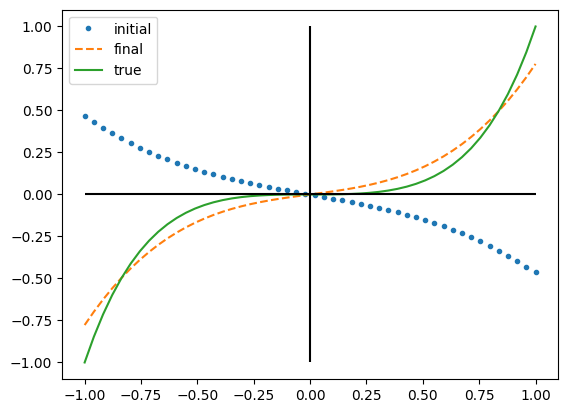

In [7]:
y_vals_init = [circ(a, phi_initial) for a in samples_a]  # Generate polynomial transform over the samples
y_vals_final = [circ(a, phi) for a in samples_a]
true_y_vals = [target_poly(a) for a in samples_a]

plt.plot(samples_a, y_vals_init, ".", label="initial")
plt.plot(samples_a, y_vals_final, "--", label="final")
plt.plot(samples_a, true_y_vals, label="true")
plt.vlines(0.0, -1.0, 1.0, color="black")
plt.hlines(0.0, -1.0, 1.0, color="black")
plt.legend()
plt.show()

### Angle Solver

In [11]:
from numpy.polynomial.polynomial import Polynomial as Poly

qubit_register = ["ancilla", 0]
dev = qml.device("default.qubit", wires=qubit_register)

@qml.qnode(dev)
def qsvt_circ(a, phi):
    # Hadamard transform on the input register
    qml.Hadamard("ancilla")

    qml.ctrl(qml.qsvt, control="ancilla")(a, phi, wires=[0])  # apply controlled qsvt circuit!

    # Another Hadamard transform on the input register
    qml.Hadamard("ancilla")

    return qml.expval(qml.PauliZ("ancilla"))

def qsvt_phases(poly_coeffs, method="default", accuracy=1e-2, max_iteration=200, verbose=False):
    """Optimize qsvt phases for the given polynomial"""
    degree = len(poly_coeffs) - 1

    # get samples
    num_samples = max(10, degree + 1)
    samples = get_samples(num_samples, method=method)

    # split even and odd coeffs
    even_coeffs = [coeff if i % 2 == 0 else 0.0 for i, coeff in enumerate(poly_coeffs)]
    odd_coeffs = [coeff if (i + 1) % 2 == 0 else 0.0 for i, coeff in enumerate(poly_coeffs)]

    even_degree = degree
    odd_degree = degree

    if degree % 2 == 0:
        odd_coeffs = odd_coeffs[:-1]  # remove last entry because it is a 0.0
        odd_degree = degree - 1
    else:
        even_coeffs = even_coeffs[:-1]
        even_degree = degree - 1

    even_phi_init = get_init_phi(even_degree)
    odd_phi_init = get_init_phi(odd_degree)

    # validation + execution:
    zero_even = np.allclose(even_coeffs, np.zeros(even_degree + 1), atol=1e-8)
    zero_odd = np.allclose(odd_coeffs, np.zeros(odd_degree + 1), atol=1e-8)

    if zero_even and zero_odd:
        raise ValueError("Recieved 0 polynomial to approximate")

    elif zero_even:
        optimized_phi_odd = run_optimizer(odd_phi_init, Poly(odd_coeffs), accuracy=accuracy, max_iter=max_iteration, samples=samples,
                                          verbose=verbose)
        return (optimized_phi_odd, None)

    elif zero_odd:
        optimized_phi_even = run_optimizer(even_phi_init, Poly(even_coeffs), accuracy=accuracy, max_iter=max_iteration,
                                           samples=samples, verbose=verbose)
        return (None, optimized_phi_even)

    optimized_phi_odd = run_optimizer(odd_phi_init, Poly(odd_coeffs), accuracy=accuracy, max_iter=max_iteration, samples=samples,
                                      verbose=verbose)
    optimized_phi_even = run_optimizer(even_phi_init, Poly(even_coeffs), accuracy=accuracy, max_iter=max_iteration, samples=samples,
                                       verbose=verbose)

    return optimized_phi_odd, optimized_phi_even


def get_samples(num_s, method="default"):
    if method == "l-bfgs":
        d_tilde = np.ceil((num_s + 1) / 2)
        return np.cos([np.pi * (2 * k - 1) / (4 * d_tilde) for k in range(1, d_tilde + 1)])

    return np.linspace(-1, 1, num_s)  # uniformly sample the domain


def get_init_phi(dim):
    zero_params = np.zeros(dim)
    zero_params[0] = np.pi / 4
    zero_params[-1] = np.pi / 4
    return zero_params


def run_optimizer(init_phi, target_poly, accuracy, max_iter, samples, verbose=False):
    """Initialize and execute optimization, return results."""
    from pennylane.optimize import AdagradOptimizer

    # initialize hyper parameters:
    phi = copy.copy(init_phi)
    step_size = 0.5
    opt = AdagradOptimizer(step_size)

    # loss function:
    def _mean_squared_error(phi):
        norm = 1 / len(samples)
        sum_square_error = 0

        for x in samples:
            sum_square_error += (qsvt_circ(x, phi) - target_poly(x)) ** 2

        return norm * sum_square_error

    i = 0
    cost = accuracy
    while i < max_iter and cost >= accuracy:
        phi, cost = opt.step_and_cost(_mean_squared_error, phi)

        if verbose and i % 10 == 0:
            print(f"iter: {i}, cost: {cost}")
        i += 1
        
    
    if verbose:
        print("Done optimization!\n")
    return i, cost, phi

In [ ]:
# Definite Parity Poly

poly_coeffs = [0.0, 0.25, 0, 0.5]  # 1/2 * x^3 + 1/4 * x
odd_phi_data, even_phi_data = qsvt_phases(poly_coeffs)

print(odd_phi_data)
print(even_phi_data)

In [12]:
# Mixed Parity Poly

poly_coeffs = [1/4, 1/4, 1/4, 1/4]  # 1/4 * (1 + x + x**2 + x**3)  
odd_phi, even_phi = qsvt_phases(poly_coeffs)

print(odd_phi)
print(even_phi)

(5, tensor(0.00132534, requires_grad=True), tensor([ 0.57932979, -0.33441846,  0.75734904], requires_grad=True))
(5, tensor(0.00923167, requires_grad=True), tensor([ 1.24475017, -0.04765262], requires_grad=True))


In [21]:
poly_coeffs = [1/5, -1/5, 1/5, 1/5, -1/5]
odd_phi_data, even_phi_data = qsvt_phases(poly_coeffs, accuracy=1e-4, max_iteration=150, verbose=True)

print("\n", odd_phi_data, even_phi_data)

iter: 0, cost: 0.002734181216729617
iter: 10, cost: 0.0049944104497303375
iter: 20, cost: 0.0012192292337933558
iter: 30, cost: 0.0011411979563935553
iter: 40, cost: 0.0010688634792745684
iter: 50, cost: 0.0009991233899245117
iter: 60, cost: 0.0009317646997711685
iter: 70, cost: 0.000866645911924322
iter: 80, cost: 0.0008036861268205507
iter: 90, cost: 0.0007428566266934245
iter: 100, cost: 0.0006841727857464251
iter: 110, cost: 0.000627685977739709
iter: 120, cost: 0.0005734752880241851
iter: 130, cost: 0.0005216389682666432
iter: 140, cost: 0.0004722856986352774
Done optimization!

iter: 0, cost: 0.10293300694293926
iter: 10, cost: 0.008863209922349553
iter: 20, cost: 0.004259825991461809
iter: 30, cost: 0.001935002259409086
iter: 40, cost: 0.0013837503931705545
iter: 50, cost: 0.0010888070826536587
iter: 60, cost: 0.0008781793886113575
iter: 70, cost: 0.0007190803546605065
iter: 80, cost: 0.0005961027503281569
iter: 90, cost: 0.0004993808014853815
iter: 100, cost: 0.0004221752641224